In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchmetrics.regression import MeanSquaredError

import optree

from astra.torch.models import MLPRegressor
from astra.torch.utils import train_fn
from astra.torch.data import load_cifar_10, load_mnist

/home/patel_zeel/ASTRA/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/patel_zeel/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


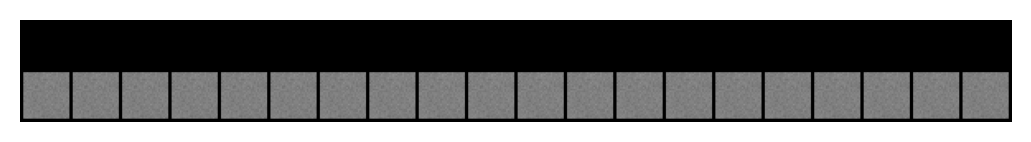

In [3]:
try:
    import astra
except ModuleNotFoundError:
    %pip install -U git+https://github.com/sustainability-lab/ASTRA

# %%
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import seaborn as sns
import pandas as pd

dist =torch.distributions
import torchsummary

sns.reset_defaults()
sns.set_context(context="talk", font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

from functools import partial

# %%
n_epochs = 100

# %%
from astra.torch.data import load_mnist
from astra.torch.utils import train_fn

# %%
# Create a sine activation class similar to ReLU
class Sine(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.tensor(1.0))
        self.b = nn.Parameter(torch.tensor(0.0))
        
    def forward(self, x):
        return torch.sin(self.w * x + self.b)

# %%
# Autoencoder class with 1 hidden layer and hidden dim = z
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=128, z=2, act = nn.ReLU()):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            act, # Using Sine activation
            nn.Linear(hidden_size, z)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z, hidden_size),
            act,
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Sigmoid activation for reconstruction
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# %%
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# %%
dataset = load_mnist()
dataset

# %%
# Train over 1000 images
train_idx = torch.arange(1000)

X = dataset.data[train_idx].to(device)
# Add a channel dimension
X = X.unsqueeze(1).float()

X = X/255.0

model = Autoencoder(input_size=784, hidden_size=128, z=32,act=Sine()).to(device)

# %%
X.shape

# %%
model(X.view(-1, 28*28*1)).shape

# %%
# Get reconstruction
def get_reconstruction(model, X, model_type='MLP'):
    with torch.no_grad():
        model.eval()
        if model_type == 'MLP':
           X = X.view(-1, 28*28*1)
        X_hat = model(X)
        if model_type == 'MLP':
           X_hat = X_hat.view(-1, 1, 28, 28)
        return X_hat

# %%
r = get_reconstruction(model, X)
r.max(), r.min(), r.shape

# %%
nn.MSELoss()(r, X)

# %%
# Plot original and reconstructed images
def plot_reconstructions(model, X, n=5, model_type='MLP'):
    X = X[:n]
    X_hat = get_reconstruction(model, X, model_type=model_type)
    # Use torchvision.utils.make_grid to make a grid of images
    X_grid = torch.cat([X, X_hat], dim=0)
    X_grid = torchvision.utils.make_grid(X_grid, nrow=n)
    plt.imshow(X_grid.cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

# %%
plot_reconstructions(model, X, 20)

# %%
iter_losses, epoch_losses = train_fn(model=model, 
                                     input=X.view(-1, 28*28),
                                     output=X.view(-1, 28*28),
                                     loss_fn=nn.MSELoss(),
                                     lr=0.01,
                                     epochs=1000,
                                     verbose=False,
                                        batch_size=500)